# MCMC Plots v2
This notebook is to produce relevant results plots for MCMC data

v2 is a streamlined version incorporating features present as of 5 May 2020
It uses results calculated in the notebook R68_MCMC_process

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *
import R68_spec_tools as spec
import R68_yield as Yield
from tqdm.notebook import tqdm
from matplotlib.pyplot import *

../mplstyles
3.4.2
/mnt/d/git/R68_paper2019/mplstyles
dict_keys(['xx', 'yy', 'ex', 'ey'])


In [3]:
#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def Fit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

In [4]:
#Load the MCMC data
import pickle as pkl

#fname='data/mcmc_Lind_128walk_5kstep_SNorm_v22.pkl'
#fname='data/mcmc_Lind_128walk_50kstep_SNorm_v1.pkl'
#fname='data/mcmc_Chav_128walk_5kstep_SNorm_v9.pkl'
#fname='data/mcmc_Sor_128walk_5kstep_SNorm_v31.pkl'
fname='data/mcmc_Sor_128walk_50kstep_SNorm_v4.pkl'
#fname='data/mcmc_AC_128walk_5kstep_SNorm_v6.pkl'
#fname='data/mcmc_Shexp_128walk_5kstep_SNorm_v1.pkl'
#fname='data/mcmc_Pol3_128walk_5kstep_SNorm_v1.pkl'

############################
basename=os.path.splitext(os.path.basename(fname))[0]

with open(fname,'rb') as file:
    mcmc_data=pkl.load(file)
sampler=mcmc_data['sampler']
guesses=mcmc_data['guesses']
labels=mcmc_data['labels']
model=mcmc_data['Y_model']
RQs=mcmc_data['RQs']

In [5]:
relabel=True
if relabel:
    for i in range(len(labels)):
        labels[i]=labels[i].replace('scale','f')
labels

['k', 'q', '$F_{NR}$', '$f_{ER}$', '$f_{NR}$', '$f_{ng}$']

In [6]:
#######Warning, rescaling factors for plotting##############
f_rescale=np.ones(len(labels))
f_rescale[5]=2.04

In [7]:
if 'll' in RQs.keys():
    print(f"{RQs['ll']:.1f}, {RQs['chisq']:.1f}/{RQs['dof']:.1f}={RQs['chisq']/RQs['dof']:.2f}")

1205.9, 71.5/189.0=0.38


In [8]:
print(f'{mcmc_data["t_run"]/60:.1f} min')
print(mcmc_data["spectrum_units"])

1567.4 min
reco-rate


In [9]:
#Look at the chain of parameter values
samples = sampler.get_chain()
ndim = samples.shape[2]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


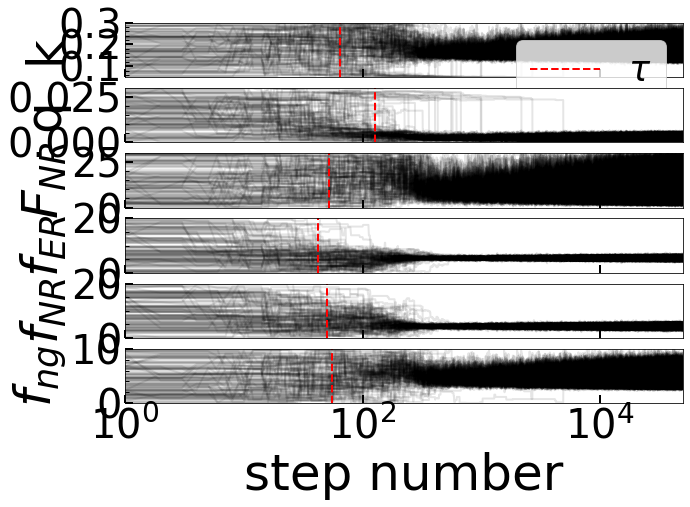

In [10]:
fig, axes = subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i]/f_rescale[i], "k", alpha=0.1)
    
    ax.axvline(mcmc_data['RQs']['taus'][i],color='r',linestyle='--',label=r'$\tau$')
    
    ax.set_xlim(1, len(samples))
    ax.set_ylim(*(mcmc_data['bounds'][i]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
axes[-1].set_xscale("log");
axes[0].legend(loc='upper right')

savefig('figures/mcmc/'+basename+'_chains.png')

Text(0, 0.5, 'Counts')

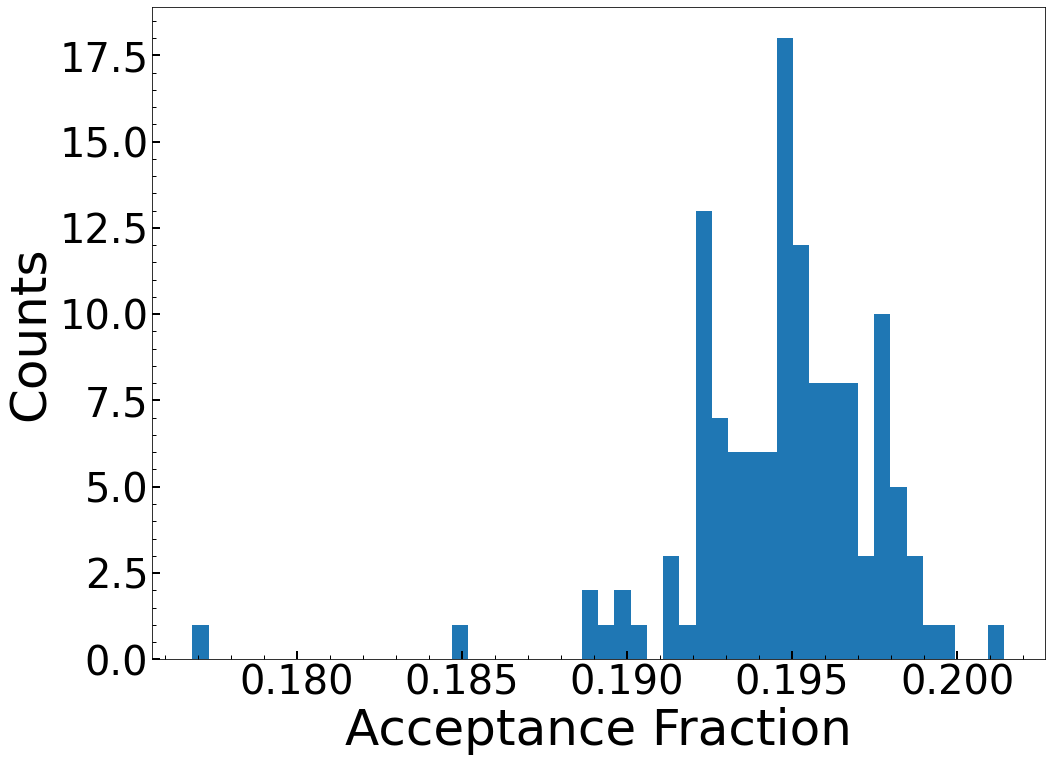

In [11]:
hist(sampler.acceptance_fraction,bins=50);
xlabel('Acceptance Fraction')
ylabel('Counts')

In [12]:
tau=sampler.get_autocorr_time(tol=0)
maxtau=RQs['maxtau']
print(f'Max tau={maxtau:.1f}')
print(f'Full chain is {samples.shape[0]/maxtau:.1f} tau_max long')
#Discard a few times tau as burn-in and thin by tau/2
flat_samples = sampler.get_chain(discard=int(2.*maxtau), thin=int(round(maxtau/2.)), flat=True)
print(flat_samples)
print(len(flat_samples))

Max tau=127.0
Full chain is 393.7 tau_max long
[[1.91118063e-01 3.21679895e-03 9.73833652e+00 5.20328676e+00
  4.37112827e+00 5.36350294e+00]
 [2.20413091e-01 3.93983210e-03 1.15773522e+01 5.03443781e+00
  4.96277285e+00 5.85987834e+00]
 [2.05575626e-01 3.73073204e-03 1.46609140e+01 5.64400054e+00
  4.30692562e+00 6.31262784e+00]
 ...
 [1.73419893e-01 2.63516252e-03 9.53114469e+00 4.89818918e+00
  4.97348057e+00 4.70876503e+00]
 [1.35484452e-01 1.05405639e-03 7.77893728e+00 5.56554604e+00
  3.86956383e+00 3.42114210e+00]
 [1.51680532e-01 1.83831792e-03 7.90597798e+00 5.07429588e+00
  4.66583463e+00 4.16178030e+00]]
99456


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


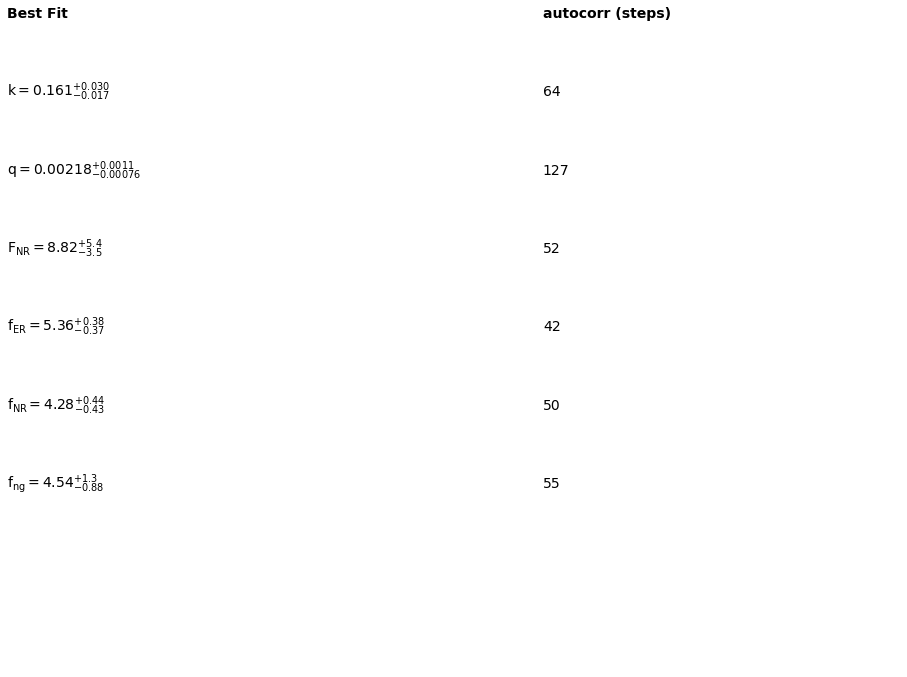

In [13]:
#Save a figure of some stats
fig,ax=plt.subplots()
ax.text(0,1,r'Best Fit',fontsize=14,fontweight='bold');
ax.text(0.6,1,r'autocorr (steps)',fontsize=14,fontweight='bold');

#txt = r'$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$'
txt = r'$\mathrm{{{3}}} = {0:#.3g}_{{-{1:#.2g}}}^{{+{2:#.2g}}}$'
for i in range(ndim):
    line = txt.format(RQs['theta'][i]/f_rescale[i], RQs['dtheta'][i][0]/f_rescale[i], RQs['dtheta'][i][1]/f_rescale[i], labels[i].replace('$',''))
    #ax.text(0,i*0.1,r'$\mathrm{F_{NR}}$',fontsize=14)
    ax.text(0,1-(i+1)*0.12,line,fontsize=14);
    ax.text(0.6,1-(i+1)*0.12,'{0:.0f}'.format(tau[i]),fontsize=14);
ax.axis('off');
plt.savefig('figures/mcmc/'+basename+'_stats.png')

In [14]:
#Copy/paste params
txt = r'$\mathrm{{{3}}} = {0:#.3g}_{{-{1:#.2g}}}^{{+{2:#.2g}}}$'
for i in range(ndim):
    line = txt.format(RQs['theta'][i]/f_rescale[i], RQs['dtheta'][i][0]/f_rescale[i], RQs['dtheta'][i][1]/f_rescale[i], labels[i].replace('$',''))
    print(line)

$\mathrm{k} = 0.161_{-0.017}^{+0.030}$
$\mathrm{q} = 0.00218_{-0.00076}^{+0.0011}$
$\mathrm{F_{NR}} = 8.82_{-3.5}^{+5.4}$
$\mathrm{f_{ER}} = 5.36_{-0.37}^{+0.38}$
$\mathrm{f_{NR}} = 4.28_{-0.43}^{+0.44}$
$\mathrm{f_{ng}} = 4.54_{-0.88}^{+1.3}$


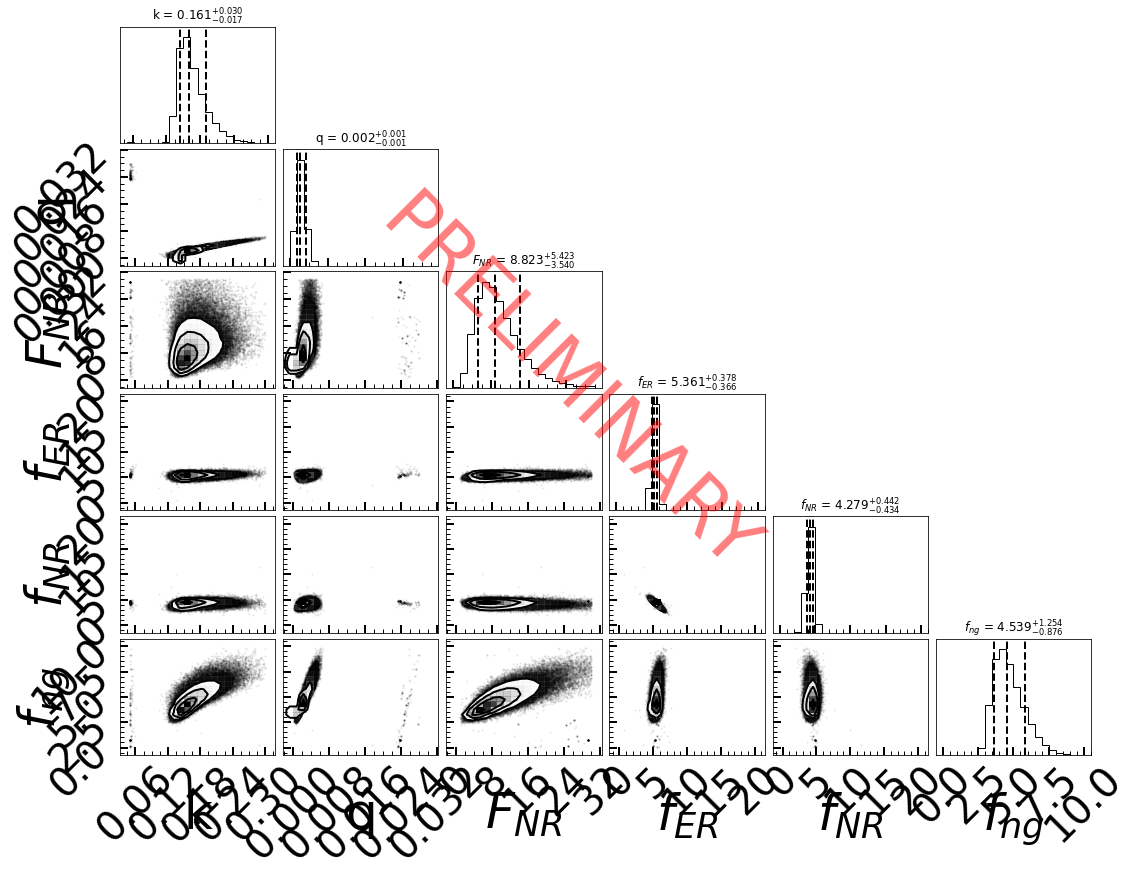

In [15]:
#Make the corner plots
import corner

#Full prior range
fig_w=15
fig,ax = subplots(ndim,ndim,figsize=(fig_w, fig_w*(.75)))

fig = corner.corner(
    flat_samples/f_rescale, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f', 
    fig=fig,range=mcmc_data['bounds']);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
savefig('figures/mcmc/'+basename+'_corner_full.png')

<Figure size 1152x864 with 0 Axes>

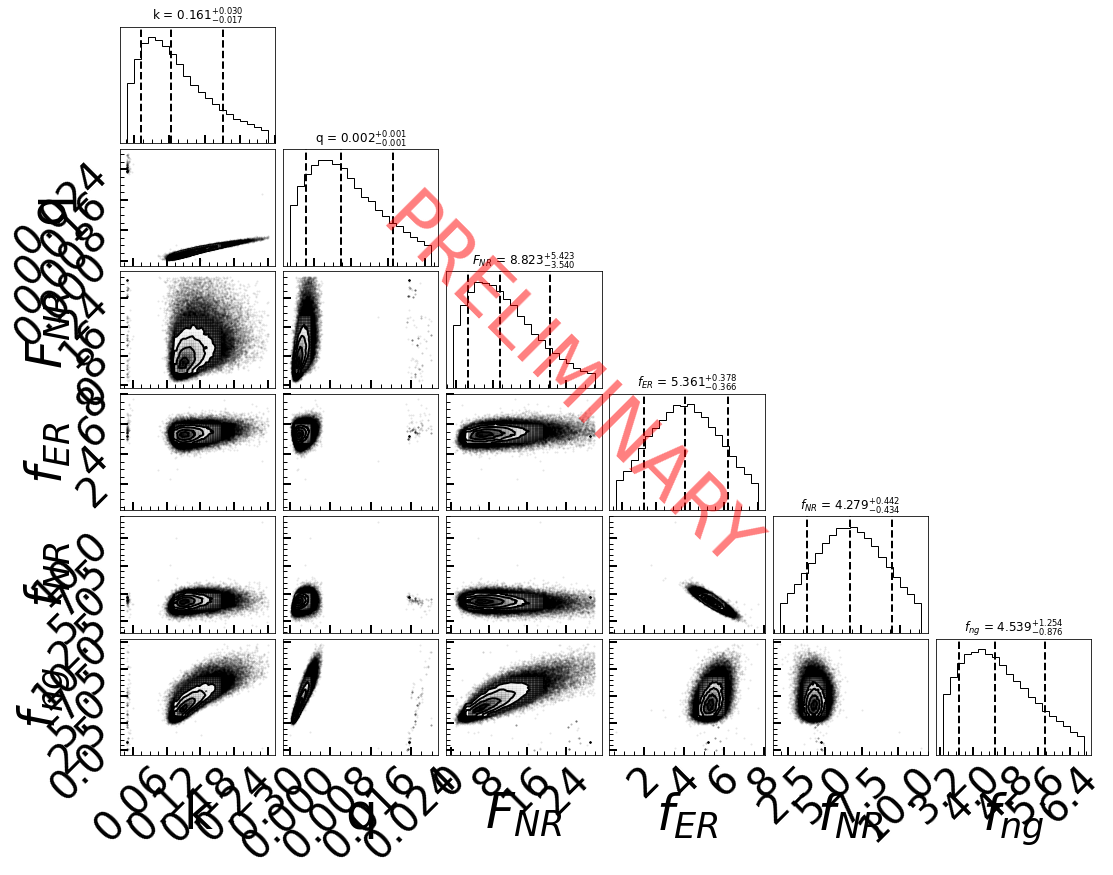

In [16]:
#Zoomed version
plt.clf()
fig,ax = subplots(ndim,ndim,figsize=(fig_w, fig_w*(.75)))
fig = corner.corner(
    flat_samples/f_rescale, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f',
    fig=fig,range=[np.percentile((flat_samples/f_rescale)[:,_], [5, 95]) for _ in range(ndim)]);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
savefig('figures/mcmc/'+basename+'_corner.png')

<Figure size 1152x864 with 0 Axes>

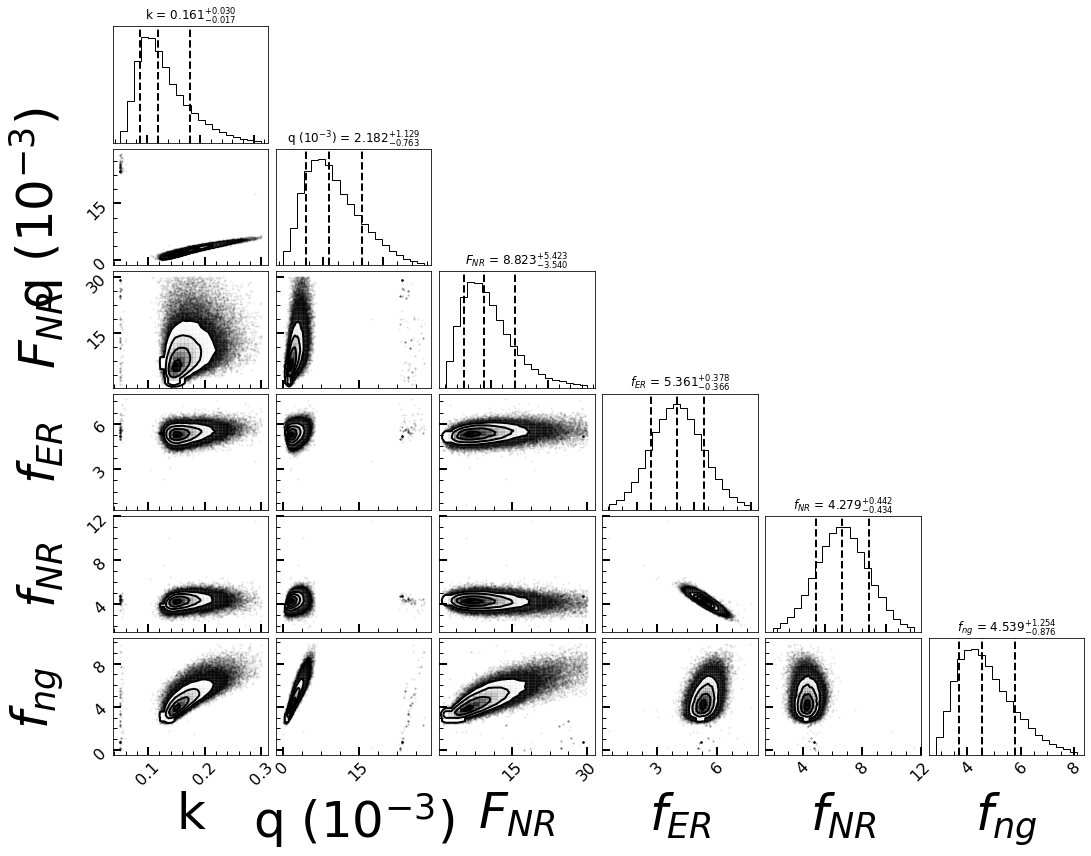

In [17]:
#Pretty version of Sorensen
plt.clf()

labsize_temp=rcParams['xtick.labelsize']
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

fig,ax = subplots(ndim,ndim,figsize=(fig_w, fig_w*(.75)))
#ranges=[[0.145,0.165],[0.0016,0.0023],[3.5,6],[3.8,4.3],[5.3,5.9],[3.4,4.1]]
flat_samples_plot=flat_samples/f_rescale*np.array([1,1e3,1,1,1,1])
labels_plot=labels.copy()
labels_plot[1]+=' ($10^{-3}$)'

fig = corner.corner(
    flat_samples_plot, labels=labels_plot, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f',
    fig=fig,range=0.99*np.ones(ndim),max_n_ticks=3);


matplotlib.rc('xtick', labelsize=labsize_temp)
matplotlib.rc('ytick', labelsize=labsize_temp)

#fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
savefig('figures/mcmc/'+basename+'_corner_pretty.png')

In [18]:
#help(corner.corner)
#help(ax[0,0].set_xticklabels)

In [19]:
#rcParams.keys()

# Show best fit spectrum
Copied this code right out of the R68_MCMC_MPI file

In [20]:
import R68_load as r68
import R68_spec_tools as spec
#Import likelihood functions
from likelihoods import *

#Set eVee energy binning
Emax=mcmc_data['Emax']
Ebins=mcmc_data['Ebins']
Ebins_ctr=(Ebins[:-1]+Ebins[1:])/2

#Set fit range
E_lim_min=mcmc_data['Efit_min'] #eVee
E_lim_max=mcmc_data['Efit_max'] #eVee
spec_bounds=(np.digitize(E_lim_min,Ebins)-1,np.digitize(E_lim_max,Ebins)-1)
mcmc_data['spec_bounds']=spec_bounds

/home/gerudo7/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3455: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]


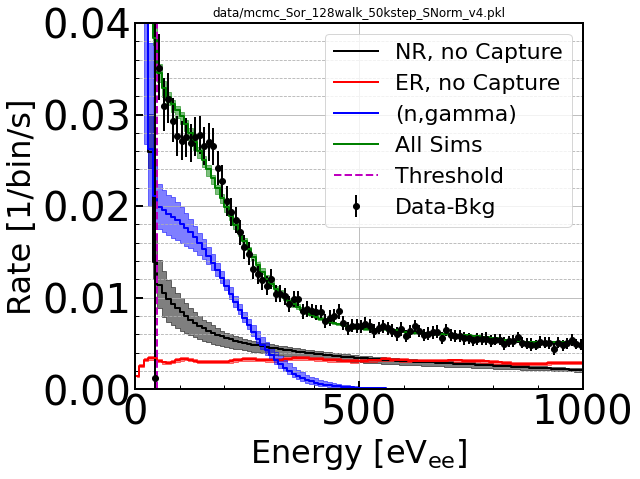

In [21]:
saveSpec=True #Save the plot

if mcmc_data['spectrum_units']=='counts':
    yrange=(0,3e3)
elif mcmc_data['spectrum_units']=='reco-rate':
    yrange=(0,4e-2)
#Make the plot
ax=spec.plotSpectra(E_bins=Ebins, N_nr=RQs['N_nr_plot'], N_er=RQs['N_er_plot'], N_ng=RQs['N_ng_plot'], N_tot=RQs['N_tot_plot'],
                    N_meas=RQs['N_meas'], dN_meas=RQs['dN_meas'],
                    xrange=(0,1e3), yrange=yrange, thresh=Ebins[np.digitize(mcmc_data['Efit_min'],Ebins)-1],
                    wResidual=False, yrange_res=(-100,100))
        
ax.set_title(fname)
#gcf().text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=50, alpha=0.5);
if saveSpec:
    savefig('figures/mcmc/'+basename+'_spectrum.png')

(0.0, 0.04)

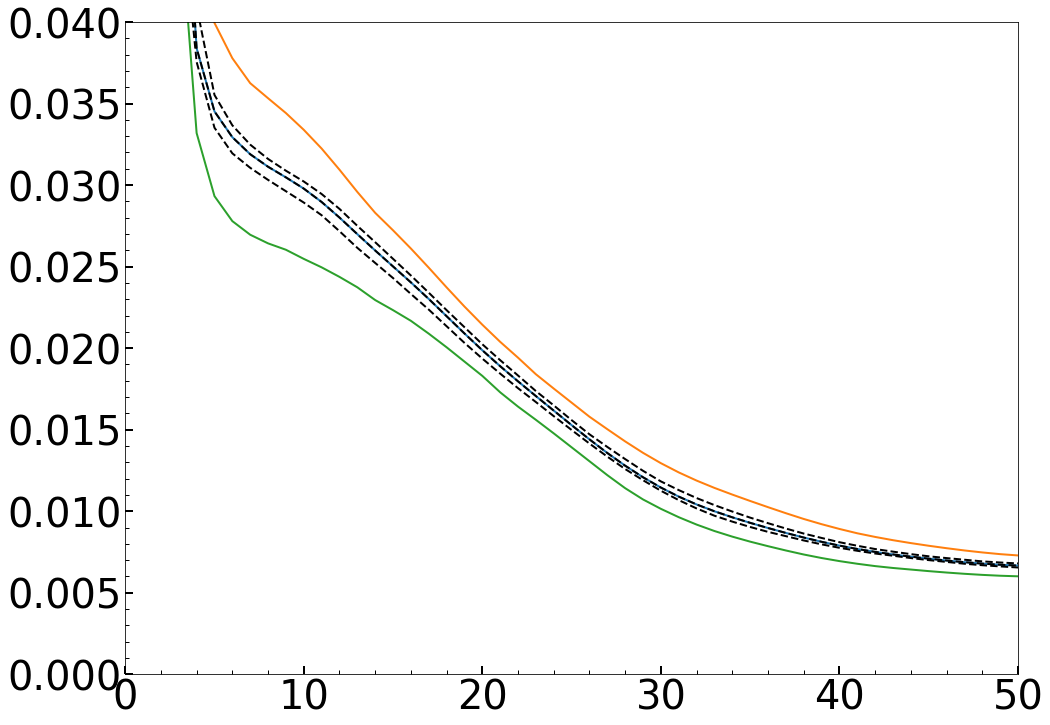

In [22]:
#Quick check
for a,b,c,d in zip(RQs['N_nr_plot'],RQs['N_er_plot'],RQs['N_ng_plot'],RQs['N_tot_plot']):
    plt.plot(a+b+c)
    plt.plot(d,'k--')
plt.xlim(0,50)
plt.ylim(0,0.04)

In [23]:
#Best fit chisq and Likelihood
print(f'Chisq/DOF:\t{RQs["chisq"]:.4g}/{RQs["dof"]}=\t{RQs["chisq"]/RQs["dof"]:.3g}\nlogLikelihood:\t{RQs["ll"]:.4g}')

Chisq/DOF:	71.47/189=	0.378
logLikelihood:	1206


# Yield curve

In [24]:
from scipy.optimize import fsolve
from scipy.special import erf

def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

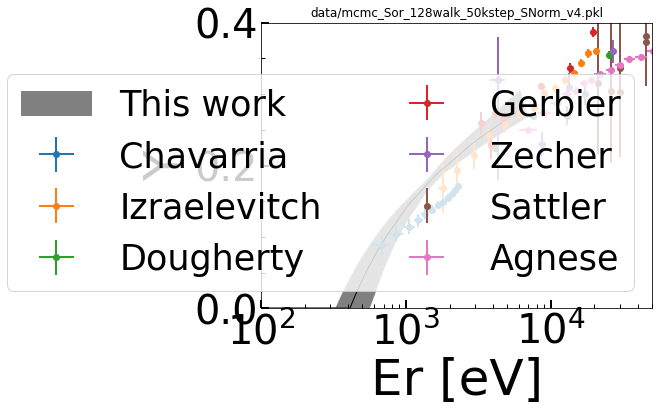

In [25]:
import R68_plot_tools as pt
import matplotlib.patches as mpatches

fig_w=7
fig,ax = subplots(1,1,figsize=(fig_w, fig_w*(.75)))

#Add other measurements from lit
pt.plotOldYs(ax,fmt='o')

#Ydist=RQs['Ydist']
#ax.fill_between(RQs['Er_Ycalc'],Ydist[1],Ydist[2],color='gray', label='This work')
#ax.plot(RQs['Er_Ycalc'], Ydist[0], '-k', linewidth=1)

Er_Ycalc_plot=np.concatenate((RQs['Er_Ycalc'][0][:1],RQs['Er_Ycalc'][1],RQs['Er_Ycalc'][0][-1:],RQs['Er_Ycalc'][2][::-1]))
Ydist_plot=np.concatenate((RQs['Ydist'][0][:1],RQs['Ydist'][1],RQs['Ydist'][0][-1:],RQs['Ydist'][2][::-1]))

ax.fill(Er_Ycalc_plot,Ydist_plot,color='gray', label='This work')
ax.plot(RQs['Er_Ycalc'][0],RQs['Ydist'][0],'k', linewidth=1)


#Manually add legend entry
handles, Ylabels = ax.get_legend_handles_labels()
patch = mpatches.Patch(facecolor='lightgray',edgecolor='k', label='This work')
handles.append(patch) 

#ax.legend(handles=handles, loc='upper left')
ax.legend(loc='lower right',ncol=2)

ax.set_xscale('log')
ax.set_xlabel('Er [eV]')
ax.set_ylabel('Y')
#ax.set_xlim(1e2,1e5);
#ax.set_ylim(0,0.5);
ax.set_xlim(1e2,5e4);
ax.set_ylim(0,0.4);
#ax.grid()

ax.set_title(fname)
#fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

savefig('figures/mcmc/'+basename+'_yield_compare.png')